# EDA for UNSW-NB15 Data Set

I've taken two datasets of point anomaly data down from the website. The first contains pre-partioned CSV files for a training and test set of data. The rows in these files have eliminated columns pertaining to specific IP address and port numbers, as well as eliminated two columns that indicated when the connectioned was opened and closed. I did all of my EDA for that dataset using only the training data CSV file. This training set contains just under 180k observations and is housed in the generically named dataframe `data`.

The second dataset consists of four larger CSV files that contain slightly less polished data. There are some missing values that had to be explained and accounted for (as can be seen in the more involved transformations). These files also include IP addresses and ports used for the observation, as well as date time values. There is also one feature, `rate`, in the pre-partitioned set that is not in these files. Because there are more than 2.5M observations across these four CSV files, I've put them together and used them for my analysis. This dataset is housed in a dataframe referred to as `all_data` in this notebook.

In [263]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Modeling Imports
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.metrics import confusion_matrix, roc_auc_score

In [272]:
def reduce_column(s, to_keep):
    '''
    Reduces the string values found in a column
    to the values provided in the list 'to_keep'.
    ---
    Input:
        s: string
        to_keep: list of strings
    Returns:
        string, s if s should be kept, else 'other'
    '''
    s = s.lower().strip()
    if s not in to_keep:
        return 'other'
    else:
        return s

In [358]:
data = pd.read_csv('./data/UNSW_NB15_train_set.csv', header=0, index_col=0)
len(data.columns)

44

In [440]:
data.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
id,,,,,,,,,,,,,,,,,,,,,
1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,0,0,0,1,1,0,Normal,0
2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,2,0,0,0,1,6,0,Normal,0
3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,3,0,0,0,2,6,0,Normal,0
4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,3,1,1,0,2,1,0,Normal,0
5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,1,40,0,0,0,2,39,0,Normal,0


In [6]:
data.columns

Index(['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')

Note that IP address and port numbers are not included in the data set, and that we've used the id column as an index.
* id
* srcip
* sport
* dstip
* dsport  

This brings us to 44 data columns that we'll have to use as features.

In [7]:
n_obs = data.shape[0]
print(n_obs)

175341


In [8]:
# Number of invalid data
data.isnull().sum().sum()

0

In [9]:
data.attack_cat.unique()

array(['Normal', 'Backdoor', 'Analysis', 'Fuzzers', 'Shellcode',
       'Reconnaissance', 'Exploits', 'DoS', 'Worms', 'Generic'],
      dtype=object)

In [10]:
mask = data.label == 1
print("No. of attacks:", data[mask].label.size)
print("No. of normal: ", data[~mask].label.size)

No. of attacks: 119341
No. of normal:  56000


In [491]:
data.corr()['label'].sort_values(ascending=False)

label                1.000000
sttl                 0.692741
ct_state_ttl         0.577704
ct_dst_sport_ltm     0.357213
rate                 0.337979
ct_src_dport_ltm     0.305579
ct_dst_src_ltm       0.303855
ct_src_ltm           0.238225
ct_dst_ltm           0.229887
ct_srv_src           0.229044
ct_srv_dst           0.228046
sload                0.182870
ackdat               0.097364
dttl                 0.095049
tcprtt               0.081584
synack               0.058299
dur                  0.036175
sbytes               0.018576
ct_flw_http_mthd     0.015800
trans_depth          0.010801
sloss               -0.000640
sjit                -0.007069
smean               -0.010798
ct_ftp_cmd          -0.011055
is_ftp_login        -0.011055
response_body_len   -0.021361
dinpkt              -0.022887
spkts               -0.052178
djit                -0.060870
dbytes              -0.076871
dloss               -0.094685
dpkts               -0.118591
sinpkt              -0.176110
is_sm_ips_

In [50]:
# Determining unique values for each row
for col in data.columns:
    print(col, len(data[col].unique()))

dur 74039
proto 133
service 13
state 9
spkts 480
dpkts 443
sbytes 7214
dbytes 6660
rate 76991
sttl 11
dttl 6
sload 80885
dload 77474
sloss 409
dloss 370
sinpkt 76161
dinpkt 74245
sjit 77532
djit 76831
swin 13
stcpb 75265
dtcpb 75089
dwin 7
tcprtt 43319
synack 40142
ackdat 37708
smean 1357
dmean 1328
trans_depth 11
response_body_len 2386
ct_srv_src 52
ct_state_ttl 5
ct_dst_ltm 50
ct_src_dport_ltm 47
ct_dst_sport_ltm 32
ct_dst_src_ltm 54
is_ftp_login 4
ct_ftp_cmd 4
ct_flw_http_mthd 11
ct_src_ltm 50
ct_srv_dst 52
is_sm_ips_ports 2
attack_cat 10
label 2


In [52]:
data.is_ftp_login.value_counts()

0    172774
1      2545
4        16
2         6
Name: is_ftp_login, dtype: int64

In [122]:
data.proto.value_counts()

tcp           79946
udp           63283
unas          12084
arp            2859
ospf           2595
sctp           1150
any             300
gre             225
swipe           201
pim             201
mobile          201
ipv6            201
sun-nd          201
rsvp            200
sep             193
ib              101
vmtp            100
wb-mon          100
br-sat-mon      100
wb-expak        100
srp             100
ipip            100
ipcomp          100
ipx-n-ip        100
crudp           100
ttp             100
sdrp            100
iatp            100
sat-mon         100
gmtp            100
              ...  
leaf-1           99
ip               99
prm              99
dcn              99
st2              99
chaos            99
ggp              99
leaf-2           99
trunk-1          99
emcon            99
mux              99
irtp             99
igp              99
trunk-2          99
iso-tp4          99
pup              99
cbt              99
ipnip            99
xns-idp          99


In [55]:
data.state.unique()

array(['FIN', 'INT', 'CON', 'ECO', 'REQ', 'RST', 'PAR', 'URN', 'no'],
      dtype=object)

In [58]:
data.service.unique()

array(['-', 'ftp', 'smtp', 'snmp', 'http', 'ftp-data', 'dns', 'ssh',
       'radius', 'pop3', 'dhcp', 'ssl', 'irc'], dtype=object)

In [59]:
data.sttl.unique()

array([252,  62, 254,   0,   1,  31,  63,  64,  60,  29, 255])

In [94]:
data[data.service=]

array(['FIN', 'INT', 'CON', 'ECO', 'REQ', 'RST', 'PAR', 'URN', 'no'],
      dtype=object)

# Modeling Efforts:
* One-hot encoding  
* PCA
* Random Forest Classifier
* Isolation Forest
* One-Class SVM

In [114]:
ohe = OneHotEncoder(sparse=False)
state_ohe = ohe.fit_transform(data.state.values.reshape(-1,1))

In [115]:
state_ohe.toarray()

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [116]:
ohe.categories_

[array(['CON', 'ECO', 'FIN', 'INT', 'PAR', 'REQ', 'RST', 'URN', 'no'],
       dtype=object)]

In [120]:
state_df = pd.DataFrame(state_ohe.toarray(),index=data.index, columns= ohe.categories_[0])

In [1]:
data.iloc[16]

NameError: name 'data' is not defined

In [264]:
data.merge(state_df, right_index=True, left_index=True).head()

NameError: name 'state_df' is not defined

# How distinct are the attacks and non-attacks?
Below I use PCA to quickly visualize the data in 2-D. While this may not be wholly representative of a hyper-plane, it does provide some context as to how the point anomalies relate to the normal data.

In [101]:
pca_10 = PCA(n_components=2)
data_2d = pca_10.fit_transform(X)

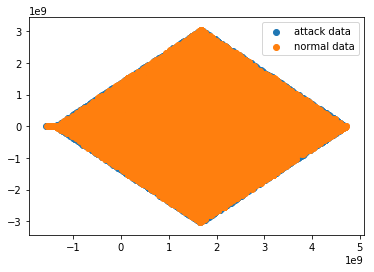

In [130]:
plt.scatter(data_2d[mask,0], data_2d[mask,1], label = 'attack data')
plt.scatter(data_2d[~mask,0], data_2d[~mask,1], label = 'normal data')
plt.legend()

In [105]:
data_2d.shape

(175341, 2)

## 3D Version

In [174]:
from mpl_toolkits.mplot3d import Axes3D

# Full Dataset EDA
Currently, the test and training set partitions are very balanced. I'm taking a look at the full dataset to explore the class balance and get a feel for the features and what they mean.

In [464]:
dfs = []
for i in range(1,5):
    path = './data/UNSW-NB15_{}.csv'
    dfs.append(pd.read_csv(path.format(i), header = None))
all_data = pd.concat(dfs).reset_index(drop=True)
all_data.columns = pd.read_csv('./data/NUSW-NB15_features.csv').Name.apply(lambda x: x.lower())


## Column cleaning steps: some of the CSV's leave the point blank for zero values.
## This results in Pandas loading in NaN values in columns where it otherwise expects numeric values. 
# Fill all NaN attack categories w/ value: 'normal'
all_data['attack_cat'] = all_data.attack_cat.fillna(value='normal').apply(lambda x: x.strip().lower())
# Replace blank spaces with zero
all_data['ct_ftp_cmd'] = all_data.ct_ftp_cmd.replace(to_replace=' ', value=0).astype(int)
# Replace NaN with zero
all_data['ct_flw_http_mthd'] = all_data.ct_flw_http_mthd.fillna(value=0)
# Replace NaN with zero and all values > 0 with 1
all_data['is_ftp_login'] = (all_data.is_ftp_login.fillna(value=0) >0).astype(int)

## Reduce categorical features into smaller sets:
## Ex: 135 unique values in `proto` become "tcp", "udp", "arp", "unas", and "other"
transformations = {
    'proto':['tcp', 'udp', 'arp', 'unas'],
    'state':['fin', 'con', 'int'],
    'service':['-', 'dns']
}
for col, keepers in transformations.items():
    all_data[col] = all_data[col].apply(reduce_column, args=(keepers,))

all_data.shape

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2540047, 49)

In [511]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2540047 entries, 0 to 2540046
Data columns (total 49 columns):
srcip               object
sport               object
dstip               object
dsport              object
proto               object
state               object
dur                 float64
sbytes              int64
dbytes              int64
sttl                int64
dttl                int64
sloss               int64
dloss               int64
service             object
sload               float64
dload               float64
spkts               int64
dpkts               int64
swin                int64
dwin                int64
stcpb               int64
dtcpb               int64
smeansz             int64
dmeansz             int64
trans_depth         int64
res_bdy_len         int64
sjit                float64
djit                float64
stime               int64
ltime               int64
sintpkt             float64
dintpkt             float64
tcprtt              float64
synack

In [465]:
# Fraction of connections that are attacks
np.sum(all_data.label == 1)/all_data.shape[0]

0.12648702957071267

In [467]:
# Confirm missing data has been addressed in processes above
all_data.isnull().sum().sum()

0

In [470]:
# Compare columns in larger csv files w/ those in partitioned training and test sets
full_cols = set(all_data.columns)
train_cols = set(data.columns)

# Number of columns the two datasets have in common:
print('No. of common columns:', len(train_cols.intersection(full_cols)))

#Columns in training data not in raw CSV's
print(train_cols - full_cols)

# Columns in raw CSV's not in training data
print(full_cols - train_cols)

No. of common columns: 38
{'response_body_len', 'smean', 'rate', 'dinpkt', 'dmean', 'sinpkt'}
{'stime', 'smeansz', 'srcip', 'dsport', 'res_bdy_len', 'dstip', 'dmeansz', 'dintpkt', 'sport', 'ltime', 'sintpkt'}


In [492]:
all_data.corr()['label'].sort_values(ascending=False)

Name
label               1.000000
sttl                0.904393
ct_state_ttl        0.873694
ct_dst_src_ltm      0.439916
ct_dst_sport_ltm    0.419056
ct_src_dport_ltm    0.396749
ct_srv_dst          0.386509
ct_srv_src          0.383007
ct_src_ltm          0.343246
ct_dst_ltm          0.339464
ltime               0.275660
stime               0.275660
sload               0.192278
ackdat              0.143443
tcprtt              0.143109
dttl                0.134947
synack              0.122253
sjit                0.020959
sbytes              0.010180
dur                 0.001959
dintpkt            -0.010632
is_sm_ips_ports    -0.015477
sintpkt            -0.019034
ct_flw_http_mthd   -0.026561
res_bdy_len        -0.027339
trans_depth        -0.029041
ct_ftp_cmd         -0.029654
is_ftp_login       -0.032642
sloss              -0.043272
djit               -0.054420
smeansz            -0.065363
dbytes             -0.075543
dloss              -0.095855
dpkts              -0.115947
spkts    

In [471]:
# Column inspection:
#col = 'ackdat'
#all_data[col].describe(), all_data[col].value_counts(dropna=False), all_data[col].hist(bins=20)

In [350]:
all_data.is_ftp_login.value_counts(dropna=False)

NaN     1429879
 0.0    1066593
 1.0      43389
 4.0        156
 2.0         30
Name: is_ftp_login, dtype: int64

In [487]:
all_data[all_data.sttl == 254].label.value_counts(sort=False)

0     33120
1    298168
Name: label, dtype: int64

In [489]:
all_data.sttl.value_counts()

31     1940700
254     331288
60      214255
62       29963
0        10448
1         4520
64        3625
29        2736
32        1602
63         526
30         225
252         84
255         75
Name: sttl, dtype: int64

In [479]:
all_data.sttl

array([ 31,   0, 254,  62,   1,  64, 255,  60,  29, 252,  32,  30,  63])

In [192]:
counts = all_data[all_data.is_sm_ips_ports == 0].label.value_counts()
counts[1]/np.sum(counts) #attack ratio: standard for whole dataset is 0.126...

0.12669627407277712

# WTF Is 'Rate'?

In [448]:
data.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
id,,,,,,,,,,,,,,,,,,,,,
1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,0,0,0,1,1,0,Normal,0
2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,2,0,0,0,1,6,0,Normal,0
3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,3,0,0,0,2,6,0,Normal,0
4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,3,1,1,0,2,1,0,Normal,0
5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,1,40,0,0,0,2,39,0,Normal,0


In [454]:
mask = (all_data.proto == 'tcp') & (all_data.service == '-')\
    & (all_data.spkts == 6) & (all_data.dbytes==172) & (all_data.dur == 0.121478)

In [455]:
all_data[mask][]

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
1087203,149.171.126.14,179,175.45.176.3,33159,tcp,fin,0.121478,258,172,252,...,0,1,1,1,1,1,1,1,normal,0


In [477]:
all_data.iloc[1087203].sttl

252

# One - Hot Encoding
Categorical features should make it into the model, but first should be narrowed to a select few values. For example, the variable `proto` identifies the connection protocol used. There are 135 different protocols in the dataset of 2.5M connections, but only 6 of the protocols occur more than a thousand times. Of those top 6, `tcp` accounts for just under 1.5M connections and `udp` for another 990k.  

Going off the heuristic that more features leads to more model complexity and associated over-fitting challenges, it would be unwise to blindly one-hot-encode this and all other categorical features. I performed some EDA where I looked at what proprotion of observations with a given categorical feature were anomalies or normal data. From those observations, I think I can reduce the categories for most categorical variables down to 3 or 4 values. For example, `proto` can be reduced to `tcp`, `udp`, `unas`, `arp`, and `other`. Other papers have proposed even fewer: `tcp`, `udp`, and `other`.

**Note that features are arranged in alphabetical order when encoded.** Using the above example, the output of a OHE would be an array with five columns, each column corresponding to `arp`, `other`, `tcp`, `udp`, `unas`, respectively.

In [295]:
ohe = OneHotEncoder(sparse=False)

In [296]:
test_proto = pd.DataFrame(ohe.fit_transform(pd.DataFrame(all_data.proto)))

In [297]:
ohe.get_feature_names()

array(['x0_arp', 'x0_other', 'x0_tcp', 'x0_udp', 'x0_unas'], dtype=object)

In [299]:
test_proto.head(), all_data.proto.head()

(     0    1    2    3    4
 0  0.0  0.0  0.0  1.0  0.0
 1  0.0  0.0  0.0  1.0  0.0
 2  0.0  0.0  0.0  1.0  0.0
 3  0.0  0.0  0.0  1.0  0.0
 4  0.0  0.0  0.0  1.0  0.0, 0    udp
 1    udp
 2    udp
 3    udp
 4    udp
 Name: proto, dtype: object)

# Pipeline Experimentation

When data is transformed in the pipeline, the original column is removed and the new data is added to the front row of the existing data structure (array, DataFrame, etc.). The columns are transformed in the order specified in the "columns to transform" parameter in the transformer tuples sent to the ColumnTransformer object. For now I will assume that the order in which they occur in the list of transformers also dictates the order in which it appears in the new data structure: the first transformations are the most to the left in the new structure, and vice versa.  

Consider some sort of scaling (min/max or standard) on your data: it smoothes the hyperplane for model fitting and hyper-parameter tuning.

In [493]:
# Define the OHE step
ohe_step = ('ohe', OneHotEncoder(sparse=False))

# Make the step part of a pipeline
ohe_pipe = Pipeline([ohe_step])

# Columns to transform
ohe_cols = ['proto', 'state', 'service']

# Transformer input: tuple w/ contents ('name', SomeTransformer(Parameters), columns)
transformer = [
    ('encoding', ohe_pipe, ohe_cols)
]

In [516]:
# Implementing and testing the column transformer
#ct = ColumnTransformer(transformers=transformer, remainder='passthrough')
ct = ColumnTransformer(transformers=transformer)

In [503]:
# Recreating column labels for transformed data
cat_cols = np.concatenate((np.sort(all_data.proto.unique()),
                           np.sort(all_data.state.unique()),
                           np.sort(all_data.service.unique())))

# Combining transformed labels with old data
new_cols =  np.concatenate((cat_cols, all_data.columns.drop(ohe_cols)))

In [517]:
#pd.DataFrame(ct.fit_transform(all_data.drop(columns=['attack_cat']))).head()
new_data = pd.DataFrame(ct.fit_transform(all_data))
#new_data.columns = new_cols

In [518]:
new_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [519]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2540047 entries, 0 to 2540046
Data columns (total 12 columns):
0     float64
1     float64
2     float64
3     float64
4     float64
5     float64
6     float64
7     float64
8     float64
9     float64
10    float64
11    float64
dtypes: float64(12)
memory usage: 232.5 MB


In [510]:
new_data[np.append(cat_cols,'label')].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2540047 entries, 0 to 2540046
Data columns (total 19 columns):
arp      object
other    object
other    object
other    object
tcp      object
udp      object
unas     object
con      object
fin      object
int      object
other    object
other    object
other    object
-        object
dns      object
other    object
other    object
other    object
label    object
dtypes: object(19)
memory usage: 368.2+ MB


In [515]:
pd.DataFrame(ct.fit_transform(X)).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2540047 entries, 0 to 2540046
Data columns (total 52 columns):
0     float64
1     float64
2     float64
3     float64
4     float64
5     float64
6     float64
7     float64
8     float64
9     float64
10    float64
11    float64
12    float64
13    float64
14    float64
15    float64
16    float64
17    float64
18    float64
19    float64
20    float64
21    float64
22    float64
23    float64
24    float64
25    float64
26    float64
27    float64
28    float64
29    float64
30    float64
31    float64
32    float64
33    float64
34    float64
35    float64
36    float64
37    float64
38    float64
39    float64
40    float64
41    float64
42    float64
43    float64
44    float64
45    float64
46    float64
47    float64
48    float64
49    float64
50    float64
51    float64
dtypes: float64(52)
memory usage: 1007.7 MB


# Pipeline Test

In [339]:
data_prep = ('data_prep', ColumnTransformer(transformers=transformer, remainder='passthrough'))
rfc_step = ('data_model', RandomForestClassifier())
model = Pipeline([data_prep, rfc_step])

In [513]:
X = all_data.drop(columns=['srcip', 'sport', 'dstip', 'dsport', 'label','attack_cat'])

In [342]:
model.fit(X,all_data.label)

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').